# Analysis of mouse fibroblast cells dataset from scSLAM-seq

Here you will learn how to analyze the mouse fibroblast cells dataset from scSLAM-seq using the CSP model with steady-state assumptions (CSPss) and comparing it to Dynamo method.

In [1]:
import dynamo as dyn
import pandas as pd
import numpy as np
import warnings
import re

warnings.filterwarnings("ignore")

/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


## Load and preprocess the data

In [2]:
tot_RNA = pd.read_csv('./data/emat_tot.txt', index_col=0, delimiter='\s')
new_RNA = pd.read_csv('./data/smat_new.txt', index_col=0, delimiter='\s')

In [3]:
from anndata import AnnData

adata_sc_slamseq_MCMV = AnnData(tot_RNA.values.T,
                                layers=dict(
                                new=new_RNA.values.T,
                                total=tot_RNA.values.T))

# again, let annotate cells by virus infection
batch = list()

for cell in tot_RNA.columns.values:
    regex = re.compile('mock')
    result = regex.search(cell)
    if result is not None:
        label = 'mock'
    else:
        label = 'mcmv'
    batch.append(label)

In [4]:
# add it to the vlm object
adata_sc_slamseq_MCMV.obs['virus'] = np.array(batch)
adata_sc_slamseq_MCMV

AnnData object with n_obs × n_vars = 87 × 583
    obs: 'virus'
    layers: 'new', 'total'

In [5]:
adata_sc_slamseq_MCMV.obs['label_time'] = 2  # this is the labeling time
tkey = 'label_time'

In [6]:
dyn.pp.recipe_monocle(adata_sc_slamseq_MCMV,
                      n_top_genes=583,
                      normalized=True,
                      keep_raw_layers=True,
                      experiment_type='one-shot',
                      tkey=tkey,
                      fg_kwargs={'shared_count': 0})
adata_sc_slamseq_MCMV

|-----> recipe_monocle_keep_filtered_cells_key is None. Using default value from DynamoAdataConfig: recipe_monocle_keep_filtered_cells_key=True
|-----> recipe_monocle_keep_filtered_genes_key is None. Using default value from DynamoAdataConfig: recipe_monocle_keep_filtered_genes_key=True
|-----> apply Monocole recipe to adata...
|-----> <insert> pp to uns in AnnData Object.
|-----------> <insert> has_splicing to uns['pp'] in AnnData Object.
|-----------> <insert> has_labling to uns['pp'] in AnnData Object.
|-----------> <insert> splicing_labeling to uns['pp'] in AnnData Object.
|-----------> <insert> has_protein to uns['pp'] in AnnData Object.
|-----> ensure all cell and variable names unique.
|-----> ensure all data in different layers in csr sparse matrix format.
|-----> ensure all labeling data properly collapased
|-----> detected experiment type: one-shot
|-----------> <insert> tkey to uns['pp'] in AnnData Object.
|-----------> <insert> experiment_type to uns['pp'] in AnnData Object

AnnData object with n_obs × n_vars = 87 × 583
    obs: 'virus', 'label_time', 'nGenes', 'nCounts', 'pMito', 'pass_basic_filter', 'Size_Factor', 'initial_cell_size', 'new_Size_Factor', 'initial_new_cell_size', 'total_Size_Factor', 'initial_total_cell_size', 'ntr'
    var: 'nCells', 'nCounts', 'pass_basic_filter', 'use_for_pca', 'frac', 'ntr'
    uns: 'pp', 'PCs', 'explained_variance_ratio_', 'pca_mean', 'pca_fit', 'feature_selection'
    obsm: 'X_pca', 'X'
    layers: 'new', 'total', 'X_new', 'X_total'

In [7]:
adata_sc_slamseq_MCMV.layers['X_new'], adata_sc_slamseq_MCMV.layers['X_total'] = adata_sc_slamseq_MCMV.layers[
                                                                                             'new'], \
                                                                                         adata_sc_slamseq_MCMV.layers[
                                                                                             'total']

## Use CSPss and Dynamo methods to infer parameters and calculate total velocity, respectively.

In [8]:
adata_sc_slamseq_MCMV_CSPss = adata_sc_slamseq_MCMV.copy()
adata_sc_slamseq_MCMV_Dynamo = adata_sc_slamseq_MCMV.copy()
del adata_sc_slamseq_MCMV

In [9]:
# for CSP with steady state
adata_sc_slamseq_MCMV_CSPss.uns["pp"]["experiment_type"] = 'kin'
dyn.tl.dynamics(adata_sc_slamseq_MCMV_CSPss, est_method='CSP4ML_CSPss', model='deterministic', tkey=tkey)
dyn.tl.reduceDimension(adata_sc_slamseq_MCMV_CSPss)
dyn.tl.cell_velocities(adata_sc_slamseq_MCMV_CSPss, ekey='M_t', vkey='velocity_T', enforce=True, basis='pca')

|-----> dynamics_del_2nd_moments_key is None. Using default value from DynamoAdataConfig: dynamics_del_2nd_moments_key=False
|-----> calculating first/second moments...


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


|-----> [moments calculation] in progress: 100.0000%
|-----> [moments calculation] finished [4.6605s]
|-----? Your adata only has labeling data, but `NTR_vel` is set to be `False`. Dynamo will reset it to `True` to enable this analysis.
|-----> experiment type: kin, method: CSP4ML_CSPss, model: deterministic


Estimate gamma via linear regression of t vs. -ln(1-K): 583it [00:00, 2516.01it/s]
Infer parameters via maximum likelihood estimation based on the CSP model under the steady-state assumption: 583it [00:00, 3250.49it/s]


(583, 1)
|-----> retrive data for non-linear dimension reduction...
|-----> perform umap...
|-----> [dimension_reduction projection] in progress: 100.0000%
|-----> [dimension_reduction projection] finished [2.3746s]
|-----> incomplete neighbor graph info detected: connectivities and distances do not exist in adata.obsp, indices not in adata.uns.neighbors.
|-----> Neighbor graph is broken, recomputing....
|-----> Start computing neighbor graph...
|-----------> X_data is None, fetching or recomputing...
|-----> fetching X data from layer:None, basis:pca
|-----> method arg is None, choosing methods automatically...
|-----------> method ball_tree selected
|-----> <insert> connectivities to obsp in AnnData Object.
|-----> <insert> distances to obsp in AnnData Object.
|-----> <insert> neighbors to uns in AnnData Object.
|-----> <insert> neighbors.indices to uns in AnnData Object.
|-----> <insert> neighbors.params to uns in AnnData Object.
|-----> 0 genes are removed because of nan velocity v

AnnData object with n_obs × n_vars = 87 × 583
    obs: 'virus', 'label_time', 'nGenes', 'nCounts', 'pMito', 'pass_basic_filter', 'Size_Factor', 'initial_cell_size', 'new_Size_Factor', 'initial_new_cell_size', 'total_Size_Factor', 'initial_total_cell_size', 'ntr'
    var: 'nCells', 'nCounts', 'pass_basic_filter', 'use_for_pca', 'frac', 'ntr', 'alpha', 'a', 'b', 'alpha_a', 'alpha_i', 'beta', 'p_half_life', 'gamma', 'half_life', 'cost', 'logLL', 'gamma_k', 'gamma_r2', 'gamma_r2_raw', 'prob_off', 'use_for_dynamics', 'use_for_transition'
    uns: 'pp', 'PCs', 'explained_variance_ratio_', 'pca_mean', 'pca_fit', 'feature_selection', 'dynamics', 'neighbors', 'umap_fit', 'grid_velocity_pca'
    obsm: 'X_pca', 'X', 'X_umap', 'velocity_pca'
    layers: 'new', 'total', 'X_new', 'X_total', 'M_t', 'M_tt', 'M_n', 'M_tn', 'M_nn', 'M_CSP_t', 'M_CSP_n', 'velocity_N', 'velocity_T', 'cell_wise_alpha'
    obsp: 'moments_con', 'distances', 'connectivities', 'pearson_transition_matrix'

In [10]:
# for Dynamo
dyn.tl.dynamics(adata_sc_slamseq_MCMV_Dynamo, model='deterministic', tkey=tkey)
dyn.tl.reduceDimension(adata_sc_slamseq_MCMV_Dynamo)
dyn.tl.cell_velocities(adata_sc_slamseq_MCMV_Dynamo, ekey='M_t', vkey='velocity_T', enforce=True, basis='pca')

|-----> dynamics_del_2nd_moments_key is None. Using default value from DynamoAdataConfig: dynamics_del_2nd_moments_key=False
|-----> calculating first/second moments...
|-----> [moments calculation] in progress: 100.0000%
|-----> [moments calculation] finished [0.7126s]
|-----? Your adata only has labeling data, but `NTR_vel` is set to be `False`. Dynamo will reset it to `True` to enable this analysis.


estimating gamma: 100%|██████████████████████| 583/583 [00:00<00:00, 731.92it/s]

|-----> retrive data for non-linear dimension reduction...
|-----> perform umap...


|-----> [dimension_reduction projection] in progress: 100.0000%
|-----> [dimension_reduction projection] finished [1.5265s]
|-----> incomplete neighbor graph info detected: connectivities and distances do not exist in adata.obsp, indices not in adata.uns.neighbors.
|-----> Neighbor graph is broken, recomputing....
|-----> Start computing neighbor graph...
|-----------> X_data is None, fetching or recomputing...
|-----> fetching X data from layer:None, basis:pca
|-----> method arg is None, choosing methods automatically...
|-----------> method ball_tree selected
|-----> <insert> connectivities to obsp in AnnData Object.
|-----> <insert> distances to obsp in AnnData Object.
|-----> <insert> neighbors to uns in AnnData Object.
|-----> <insert> neighbors.indices to uns in AnnData Object.
|-----> <insert> neighbors.params to uns in AnnData Object.
|-----> 0 genes are removed because of nan velocity values.
|-----> [calculating transition matrix via pearson kernel with sqrt transform.] in pr

AnnData object with n_obs × n_vars = 87 × 583
    obs: 'virus', 'label_time', 'nGenes', 'nCounts', 'pMito', 'pass_basic_filter', 'Size_Factor', 'initial_cell_size', 'new_Size_Factor', 'initial_new_cell_size', 'total_Size_Factor', 'initial_total_cell_size', 'ntr'
    var: 'nCells', 'nCounts', 'pass_basic_filter', 'use_for_pca', 'frac', 'ntr', 'alpha', 'beta', 'gamma', 'half_life', 'alpha_b', 'alpha_r2', 'gamma_b', 'gamma_r2', 'gamma_logLL', 'delta_b', 'delta_r2', 'bs', 'bf', 'uu0', 'ul0', 'su0', 'sl0', 'U0', 'S0', 'total0', 'beta_k', 'gamma_k', 'use_for_dynamics', 'use_for_transition'
    uns: 'pp', 'PCs', 'explained_variance_ratio_', 'pca_mean', 'pca_fit', 'feature_selection', 'dynamics', 'neighbors', 'umap_fit', 'grid_velocity_pca'
    obsm: 'X_pca', 'X', 'X_umap', 'velocity_pca'
    varm: 'alpha'
    layers: 'new', 'total', 'X_new', 'X_total', 'M_t', 'M_tt', 'M_n', 'M_tn', 'M_nn', 'M_CSP_t', 'M_CSP_n', 'velocity_N', 'velocity_T'
    obsp: 'moments_con', 'distances', 'connectivities',

## Visualization

Change the settings for better visualization:

In [16]:
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
sc.set_figure_params(scanpy=True, fontsize=7)
figsize = (6, 4)
dpi = 600
path = './rev_figures/figure2/streamline/'

### Streamline plots in first two PCA space

<Figure size 600x400 with 0 Axes>

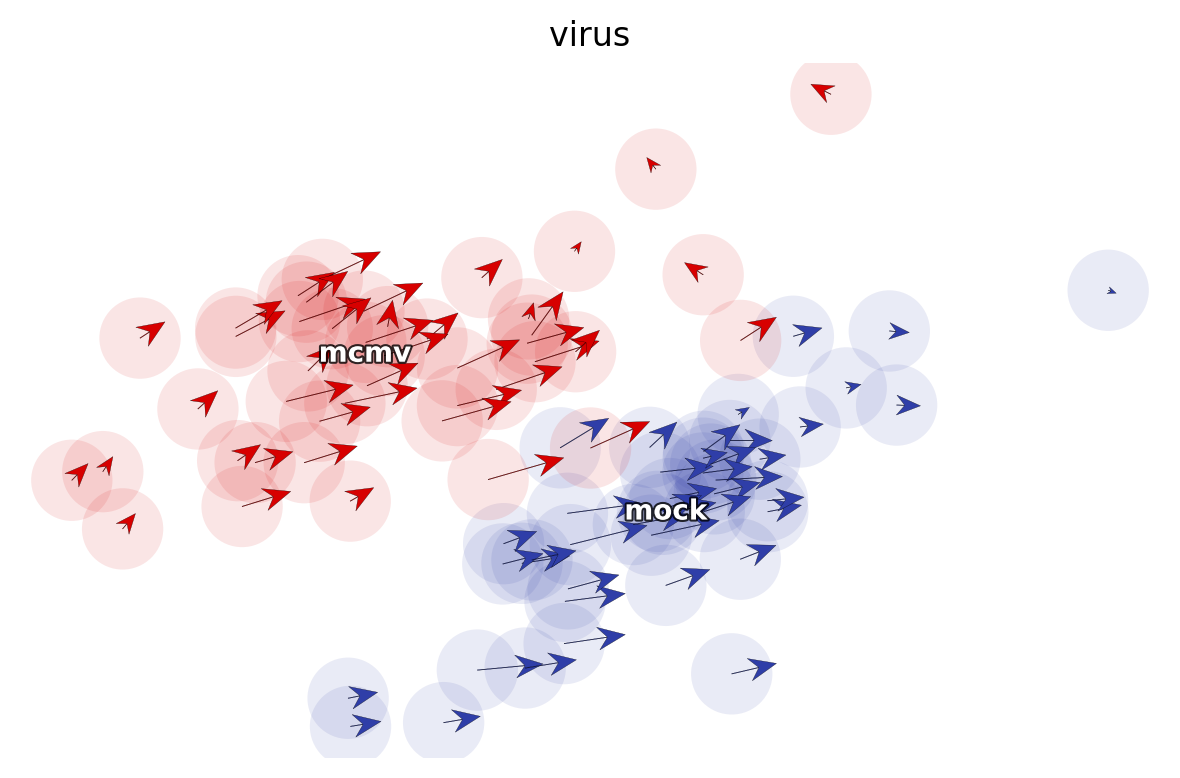

In [20]:
# CSP with steady-state
dyn.pl.cell_wise_vectors(adata_sc_slamseq_MCMV_CSPss, color=['virus'], basis='pca',
                         quiver_size=4, quiver_length=5, pointsize=0.5,
                         save_show_or_return='show', 
                         save_kwargs={'prefix': 'scSLAM_pca_cspss', 'ext': 'png',
                         "bbox_inches": None, 'dpi': dpi, 'path': path}, figsize=figsize,
                         show_legend='on data')

<Figure size 600x400 with 0 Axes>

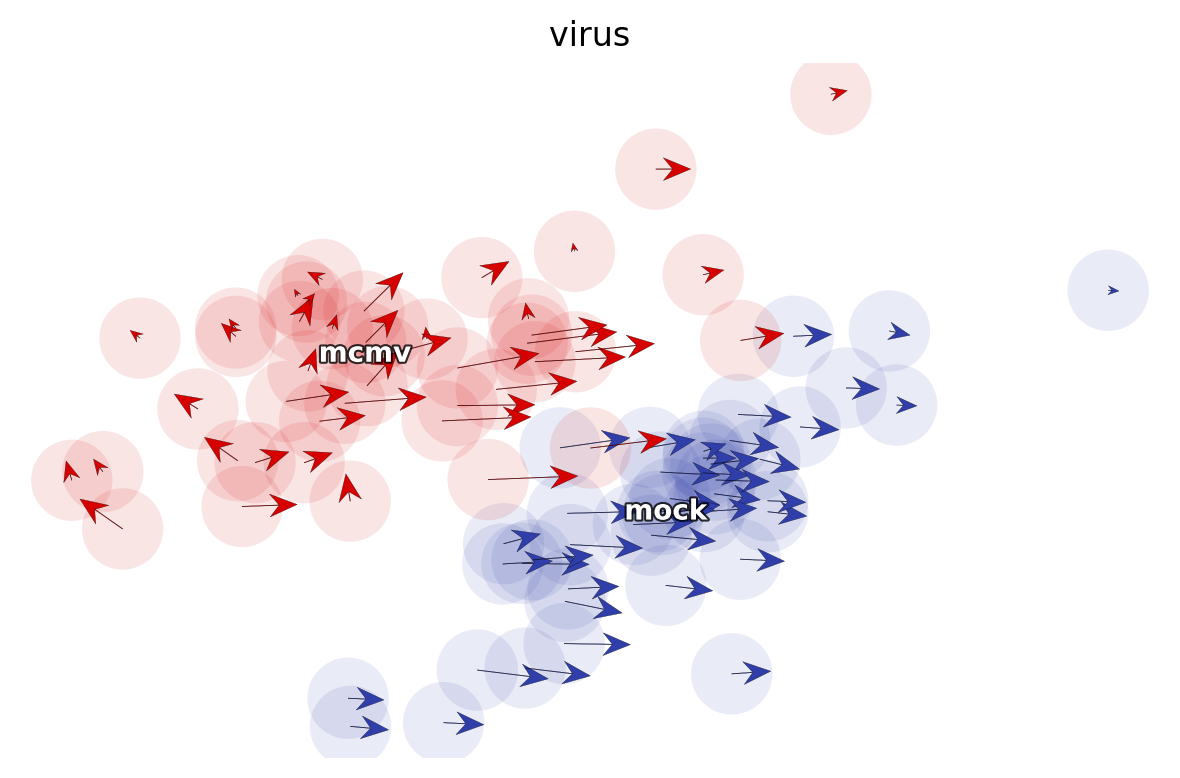

In [22]:
# Dynamo
dyn.pl.cell_wise_vectors(adata_sc_slamseq_MCMV_Dynamo, color=['virus'], basis='pca',
                         quiver_size=4, quiver_length=5, pointsize=0.5,
                         save_show_or_return='show', 
                         save_kwargs={'prefix': 'scSLAM_pca_dynamo', 'ext': 'png',
                         "bbox_inches": None, 'dpi': dpi, 'path': path}, figsize=figsize,
                         show_legend='on data')

### Plot the inferred results of $\gamma_{t}$ of the two methods

In [14]:
gamma_CSPss = adata_sc_slamseq_MCMV_CSPss.var['gamma'].values
gamma_Dynamo = adata_sc_slamseq_MCMV_Dynamo.var['gamma'].values

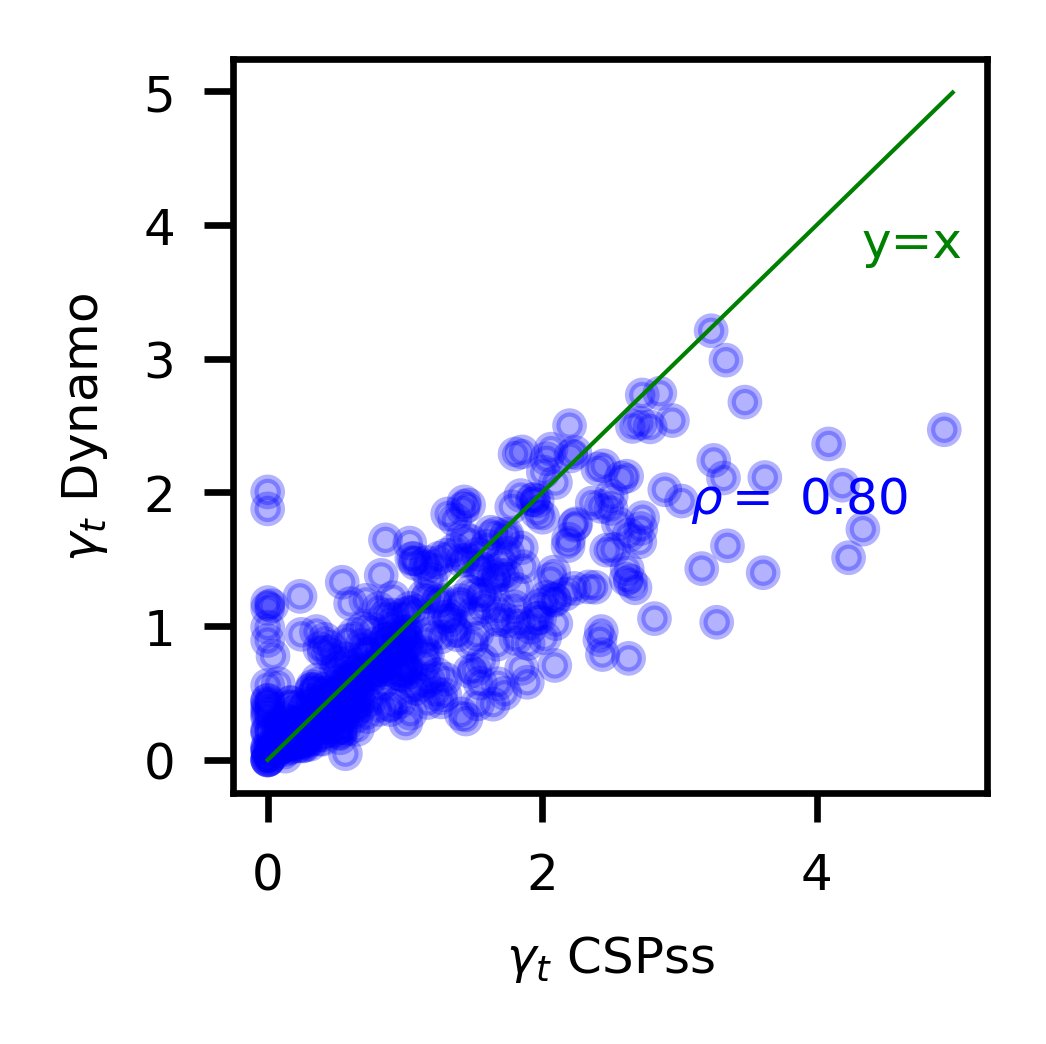

In [24]:
sc.set_figure_params(scanpy=True, fontsize=6)
scatter_size = 10
figsize = (1.61, 1.61)
alpha = 0.3
dpi = 300

gamma_CSPss = gamma_CSPss.astype('float')
gamma_Dynamo = gamma_Dynamo.astype('float')


range_min = 0
range_max = 5
x = np.arange(range_min, range_max, 0.01)
y = x

index_no_nan = np.logical_and(np.isfinite(gamma_CSPss), np.isfinite(gamma_Dynamo))
# correlation coefficient between all the genes
rho = np.corrcoef(gamma_CSPss[index_no_nan], gamma_Dynamo[index_no_nan])


fig = plt.figure(1, figsize=figsize, dpi=dpi)
ax = fig.add_subplot(111)
ax.scatter(gamma_CSPss, gamma_Dynamo, color='blue', s=scatter_size * np.ones(len(gamma_CSPss)), alpha=alpha)
ax.plot(x, y, color='g', linewidth=0.5, label='y=x')
plt.text(0.9, 0.75, 'y=x', ha='center', va='center', transform=ax.transAxes, color='g')
plt.text(0.75, 0.4, '$\\rho=$ %4.2f' % rho[0][1], 
         ha='center', va='center', transform=ax.transAxes, color='b')
plt.xlabel('$\gamma_t$ CSPss')
plt.ylabel('$\gamma_t$ Dynamo')
plt.grid(False)
plt.savefig('./rev_figures/figure2/comp/scSLAM-seq.pdf',dpi=dpi, bbox_inches="tight")
plt.show()